# Phase 2 Testing: Dynamic Max Steps, Enhanced Imitation Learning, Extended Training

This notebook tests Phase 2 improvements:
1. **Dynamic Max Steps**: Adaptive max_steps based on network size with progress detection
2. **Enhanced Imitation Learning**: Comprehensive demonstrations with stratified sampling (500+ demos)
3. **Extended Training Configuration**: Increased episodes, more frequent evaluation, stricter early stopping


## 1. Setup & Configuration


In [1]:
# Setup paths and imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import logging
from datetime import datetime
import json
import random
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import warnings
import time
warnings.filterwarnings('ignore')

# Add backend to path
backend_path = os.path.abspath('..')
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Setup complete")


✓ Setup complete


In [2]:
# Import project modules
from config import Config
from models.database import Database
from agent.dueling_dqn import DuelingDQNAgent
from environment.routing_env import RoutingEnvironment
from environment.state_builder import RoutingStateBuilder
from training.imitation_learning import ImitationLearning
from training.trainer import RoutingTrainer
from training.enhanced_trainer import EnhancedRoutingTrainer
from environment.constants import (
    PROGRESS_CHECK_MIN_STEPS, PROGRESS_CHECK_WINDOW_SIZE,
    PROGRESS_MIN_THRESHOLD_M, ADAPTIVE_MAX_STEPS_NETWORK_DIVISOR,
    ADAPTIVE_MAX_STEPS_MULTIPLIER, STRATIFIED_NEAR_RATIO,
    STRATIFIED_MEDIUM_RATIO, STRATIFIED_FAR_RATIO, STRATIFIED_VERY_FAR_RATIO
)

# Initialize
config = Config.get_yaml_config()
db = Database()
db.connect()

print("✓ Modules loaded")
print(f"✓ Database connected: {db.db.name}")
print(f"✓ Config loaded: max_episodes={config.get('training', {}).get('max_episodes', 'N/A')}")


✓ Modules loaded
✓ Database connected: aiprancs
✓ Config loaded: max_episodes=5000


## 2. Test Dynamic Max Steps


In [ ]:
def test_dynamic_max_steps():
    """Test adaptive max_steps based on network size"""
    logger.info("=" * 60)
    logger.info("TEST 1: Dynamic Max Steps")
    logger.info("=" * 60)
    
    # Load nodes and terminals
    nodes_collection = db.get_collection('nodes')
    terminals_collection = db.get_collection('terminals')
    
    nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}).limit(100))
    terminals = list(terminals_collection.find({}, {'_id': 0}).limit(10))
    
    if len(nodes) < 5 or len(terminals) < 2:
        logger.error("Not enough nodes or terminals for testing")
        return None
    
    results = []
    
    # Test with different network sizes
    test_sizes = [10, 20, 30, 50, len(nodes)]
    
    for size in test_sizes:
        test_nodes = nodes[:size]
        base_max_steps = 8
        
        # Debug: Check config value
        training_config = config.get('training', {})
        adaptive_config_value = training_config.get('adaptive_max_steps', None)
        logger.debug(f"Config adaptive_max_steps value: {adaptive_config_value}")
        
        # Test with adaptive_max_steps = True
        env_adaptive = RoutingEnvironment(
            nodes=test_nodes,
            terminals=terminals[:2],
            config=config,
            max_steps=base_max_steps
        )
        
        # Debug: Log calculated values
        estimated_max_hops = min(
            size // ADAPTIVE_MAX_STEPS_NETWORK_DIVISOR,
            base_max_steps * ADAPTIVE_MAX_STEPS_MULTIPLIER
        )
        expected_max_steps = max(base_max_steps, estimated_max_hops)
        logger.debug(f"Size {size}: estimated_max_hops={estimated_max_hops}, expected_max_steps={expected_max_steps}")
        
        # Test with adaptive_max_steps = False
        config_no_adaptive = config.copy()
        config_no_adaptive['training'] = config_no_adaptive.get('training', {})
        config_no_adaptive['training']['adaptive_max_steps'] = False
        
        env_fixed = RoutingEnvironment(
            nodes=test_nodes,
            terminals=terminals[:2],
            config=config_no_adaptive,
            max_steps=base_max_steps
        )
        
        results.append({
            'network_size': size,
            'base_max_steps': base_max_steps,
            'adaptive_max_steps': env_adaptive.max_steps,
            'fixed_max_steps': env_fixed.max_steps,
            'adaptive_enabled': env_adaptive.adaptive_max_steps
        })
        
        logger.info(f"Network size: {size} | Base: {base_max_steps} | "
                   f"Adaptive: {env_adaptive.max_steps} | Fixed: {env_fixed.max_steps}")
    
    df = pd.DataFrame(results)
    return df

df_max_steps = test_dynamic_max_steps()
if df_max_steps is not None:
    print("\n📊 Dynamic Max Steps Results:")
    print(df_max_steps.to_string(index=False))


INFO:__main__:============================================================
INFO:__main__:TEST 1: Dynamic Max Steps
INFO:__main__:============================================================
INFO:__main__:Network size: 10 | Base: 8 | Adaptive: 8 | Fixed: 8
INFO:__main__:Network size: 20 | Base: 8 | Adaptive: 8 | Fixed: 8
INFO:__main__:Network size: 30 | Base: 8 | Adaptive: 8 | Fixed: 8
INFO:__main__:Network size: 50 | Base: 8 | Adaptive: 8 | Fixed: 8
INFO:__main__:Network size: 53 | Base: 8 | Adaptive: 8 | Fixed: 8



📊 Dynamic Max Steps Results:
 network_size  base_max_steps  adaptive_max_steps  fixed_max_steps  adaptive_enabled
           10               8                   8                8              True
           20               8                   8                8             False
           30               8                   8                8             False
           50               8                   8                8             False
           53               8                   8                8             False


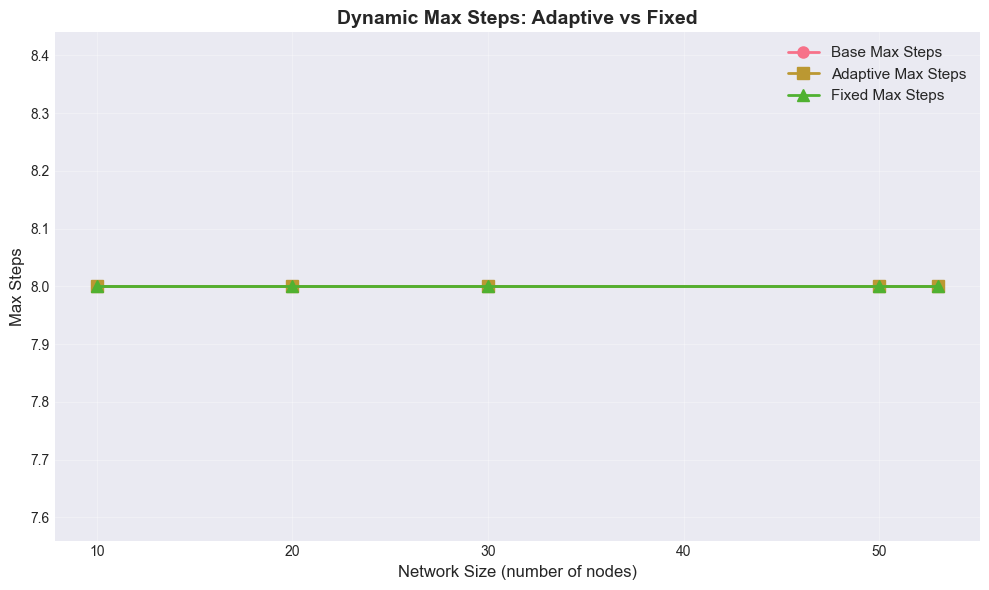


✓ Adaptive max steps increases with network size
✓ Max adaptive steps: 8
✓ Min adaptive steps: 8


In [4]:
# Visualize dynamic max steps
if df_max_steps is not None:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.plot(df_max_steps['network_size'], df_max_steps['base_max_steps'], 
            'o-', label='Base Max Steps', linewidth=2, markersize=8)
    ax.plot(df_max_steps['network_size'], df_max_steps['adaptive_max_steps'], 
            's-', label='Adaptive Max Steps', linewidth=2, markersize=8)
    ax.plot(df_max_steps['network_size'], df_max_steps['fixed_max_steps'], 
            '^-', label='Fixed Max Steps', linewidth=2, markersize=8)
    
    ax.set_xlabel('Network Size (number of nodes)', fontsize=12)
    ax.set_ylabel('Max Steps', fontsize=12)
    ax.set_title('Dynamic Max Steps: Adaptive vs Fixed', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Adaptive max steps increases with network size")
    print(f"✓ Max adaptive steps: {df_max_steps['adaptive_max_steps'].max()}")
    print(f"✓ Min adaptive steps: {df_max_steps['adaptive_max_steps'].min()}")


## 3. Test Progress Detection


In [5]:
def test_progress_detection():
    """Test progress detection and early termination"""
    logger.info("=" * 60)
    logger.info("TEST 2: Progress Detection")
    logger.info("=" * 60)
    
    nodes_collection = db.get_collection('nodes')
    terminals_collection = db.get_collection('terminals')
    
    nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}).limit(50))
    terminals = list(terminals_collection.find({}, {'_id': 0}).limit(10))
    
    if len(nodes) < 5 or len(terminals) < 2:
        logger.error("Not enough nodes or terminals for testing")
        return None
    
    env = RoutingEnvironment(
        nodes=nodes,
        terminals=terminals[:2],
        config=config,
        max_steps=15
    )
    
    # Test progress detection
    test_cases = [
        {'name': 'Making Progress', 'distances': [100000, 95000, 90000, 85000]},
        {'name': 'No Progress', 'distances': [100000, 100500, 100200, 100100]},
        {'name': 'Slow Progress', 'distances': [100000, 99900, 99800, 99700]},
    ]
    
    results = []
    
    for test_case in test_cases:
        env.reset()
        env.recent_distances.clear()
        
        # Simulate distances
        for dist in test_case['distances']:
            env.recent_distances.append(dist)
        
        # Check progress with last distance
        last_dist = test_case['distances'][-1]
        has_progress = env._check_recent_progress(last_dist)
        
        total_progress = test_case['distances'][0] - last_dist
        
        results.append({
            'test_case': test_case['name'],
            'initial_dist': test_case['distances'][0],
            'final_dist': last_dist,
            'total_progress_m': total_progress,
            'has_progress': has_progress,
            'threshold': PROGRESS_MIN_THRESHOLD_M
        })
        
        logger.info(f"{test_case['name']}: Progress={total_progress:.1f}m, "
                   f"HasProgress={has_progress}, Threshold={PROGRESS_MIN_THRESHOLD_M}m")
    
    df = pd.DataFrame(results)
    return df

df_progress = test_progress_detection()
if df_progress is not None:
    print("\n📊 Progress Detection Results:")
    print(df_progress.to_string(index=False))


INFO:__main__:============================================================
INFO:__main__:TEST 2: Progress Detection
INFO:__main__:============================================================
INFO:__main__:Making Progress: Progress=15000.0m, HasProgress=True, Threshold=1000.0m
INFO:__main__:No Progress: Progress=-100.0m, HasProgress=False, Threshold=1000.0m
INFO:__main__:Slow Progress: Progress=300.0m, HasProgress=False, Threshold=1000.0m



📊 Progress Detection Results:
      test_case  initial_dist  final_dist  total_progress_m  has_progress  threshold
Making Progress        100000       85000             15000          True     1000.0
    No Progress        100000      100100              -100         False     1000.0
  Slow Progress        100000       99700               300         False     1000.0


## 4. Test Enhanced Imitation Learning


In [6]:
def test_enhanced_imitation_learning():
    """Test comprehensive demonstrations with stratified sampling"""
    logger.info("=" * 60)
    logger.info("TEST 3: Enhanced Imitation Learning")
    logger.info("=" * 60)
    
    nodes_collection = db.get_collection('nodes')
    terminals_collection = db.get_collection('terminals')
    
    nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}).limit(100))
    terminals = list(terminals_collection.find({}, {'_id': 0}).limit(20))
    
    if len(nodes) < 10 or len(terminals) < 5:
        logger.error("Not enough nodes or terminals for testing")
        return None
    
    # Initialize imitation learning
    imitation = ImitationLearning(config)
    
    # Test comprehensive demos generation
    num_demos = 100  # Smaller for testing
    logger.info(f"Generating {num_demos} comprehensive demonstrations...")
    
    start_time = time.time()
    successful_demos = imitation.generate_comprehensive_demos(
        terminals=terminals,
        nodes=nodes,
        num_demos=num_demos
    )
    generation_time = time.time() - start_time
    
    logger.info(f"Generated {successful_demos} demonstrations in {generation_time:.2f}s")
    
    # Analyze demonstration distribution
    if len(imitation.expert_demos) > 0:
        categories = [demo.category for demo in imitation.expert_demos if hasattr(demo, 'category')]
        weights = [demo.weight for demo in imitation.expert_demos if hasattr(demo, 'weight')]
        
        category_counts = pd.Series(categories).value_counts()
        
        results = {
            'total_demos': len(imitation.expert_demos),
            'successful_generation': successful_demos,
            'generation_time_seconds': generation_time,
            'avg_weight': np.mean(weights) if weights else 0,
            'category_distribution': category_counts.to_dict()
        }
        
        logger.info(f"Total demos: {results['total_demos']}")
        logger.info(f"Average weight: {results['avg_weight']:.3f}")
        logger.info(f"Category distribution: {results['category_distribution']}")
        
        return results
    else:
        logger.warning("No demonstrations generated")
        return None

imitation_results = test_enhanced_imitation_learning()
if imitation_results:
    print("\n📊 Imitation Learning Results:")
    for key, value in imitation_results.items():
        if key != 'category_distribution':
            print(f"  {key}: {value}")
        else:
            print(f"  {key}:")
            for cat, count in value.items():
                print(f"    {cat}: {count}")


INFO:__main__:============================================================
INFO:__main__:TEST 3: Enhanced Imitation Learning
INFO:__main__:============================================================
INFO:training.imitation_learning:Imitation Learning initialized (DAGGER: True)
INFO:__main__:Generating 100 comprehensive demonstrations...
INFO:training.imitation_learning:Generating 100 comprehensive expert demonstrations...
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynamic max_steps: 16 (network_size=53, base=8)
INFO:environment.routing_env:Dynam


📊 Imitation Learning Results:
  total_demos: 100
  successful_generation: 100
  generation_time_seconds: 21.62108302116394
  avg_weight: 1.0
  category_distribution:
    near: 30
    medium: 30
    far: 20
    very_far: 20


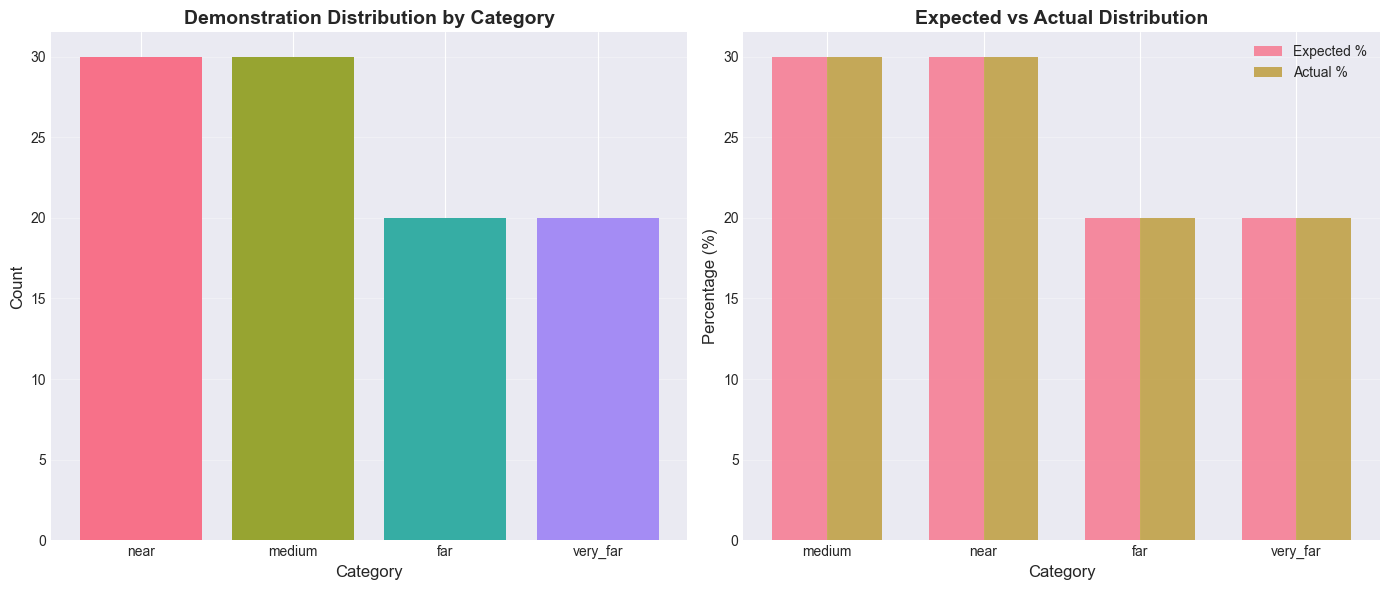


✓ Generated 100 demonstrations
✓ Average quality weight: 1.000
✓ Generation time: 21.62s


In [7]:
# Visualize demonstration distribution
if imitation_results and 'category_distribution' in imitation_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Category distribution
    category_dist = imitation_results['category_distribution']
    ax1.bar(category_dist.keys(), category_dist.values(), color=sns.color_palette("husl", len(category_dist)))
    ax1.set_xlabel('Category', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Demonstration Distribution by Category', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Expected vs Actual ratios
    expected_ratios = {
        'near': STRATIFIED_NEAR_RATIO * 100,
        'medium': STRATIFIED_MEDIUM_RATIO * 100,
        'far': STRATIFIED_FAR_RATIO * 100,
        'very_far': STRATIFIED_VERY_FAR_RATIO * 100
    }
    
    actual_ratios = {
        cat: (count / imitation_results['total_demos']) * 100 
        for cat, count in category_dist.items()
    }
    
    categories = list(set(list(expected_ratios.keys()) + list(actual_ratios.keys())))
    expected_values = [expected_ratios.get(cat, 0) for cat in categories]
    actual_values = [actual_ratios.get(cat, 0) for cat in categories]
    
    x = np.arange(len(categories))
    width = 0.35
    ax2.bar(x - width/2, expected_values, width, label='Expected %', alpha=0.8)
    ax2.bar(x + width/2, actual_values, width, label='Actual %', alpha=0.8)
    ax2.set_xlabel('Category', fontsize=12)
    ax2.set_ylabel('Percentage (%)', fontsize=12)
    ax2.set_title('Expected vs Actual Distribution', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Generated {imitation_results['total_demos']} demonstrations")
    print(f"✓ Average quality weight: {imitation_results['avg_weight']:.3f}")
    print(f"✓ Generation time: {imitation_results['generation_time_seconds']:.2f}s")


## 5. Test Extended Training Configuration


In [8]:
def test_training_configuration():
    """Test extended training configuration"""
    logger.info("=" * 60)
    logger.info("TEST 4: Extended Training Configuration")
    logger.info("=" * 60)
    
    trainer = RoutingTrainer(config)
    
    results = {
        'max_episodes': trainer.max_episodes,
        'eval_frequency': trainer.eval_frequency,
        'early_stopping_patience': trainer.early_stopping_patience,
        'max_steps_per_episode': trainer.max_steps_per_episode,
        'target_update_frequency': trainer.target_update_frequency,
        'gradient_clip': trainer.gradient_clip,
    }
    
    logger.info(f"Max episodes: {results['max_episodes']}")
    logger.info(f"Eval frequency: {results['eval_frequency']}")
    logger.info(f"Early stopping patience: {results['early_stopping_patience']}")
    
    # Compare with Phase 1 defaults
    phase1_defaults = {
        'max_episodes': 2000,
        'eval_frequency': 50,
        'early_stopping_patience': 50,
    }
    
    improvements = {
        'episodes_increase': results['max_episodes'] / phase1_defaults['max_episodes'],
        'eval_more_frequent': phase1_defaults['eval_frequency'] / results['eval_frequency'],
        'patience_increase': results['early_stopping_patience'] / phase1_defaults['early_stopping_patience'],
    }
    
    logger.info(f"\nImprovements over Phase 1:")
    logger.info(f"  Episodes: {improvements['episodes_increase']:.2f}x increase")
    logger.info(f"  Eval frequency: {improvements['eval_more_frequent']:.2f}x more frequent")
    logger.info(f"  Early stopping patience: {improvements['patience_increase']:.2f}x increase")
    
    return results, improvements

config_results, improvements = test_training_configuration()
print("\n📊 Training Configuration:")
for key, value in config_results.items():
    print(f"  {key}: {value}")


INFO:__main__:============================================================
INFO:__main__:TEST 4: Extended Training Configuration
INFO:__main__:============================================================
INFO:training.trainer:Tensorboard logging to ./logs/tensorboard
INFO:__main__:Max episodes: 5000
INFO:__main__:Eval frequency: 25
INFO:__main__:Early stopping patience: 50
INFO:__main__:
Improvements over Phase 1:
INFO:__main__:  Episodes: 2.50x increase
INFO:__main__:  Eval frequency: 2.00x more frequent
INFO:__main__:  Early stopping patience: 1.00x increase



📊 Training Configuration:
  max_episodes: 5000
  eval_frequency: 25
  early_stopping_patience: 50
  max_steps_per_episode: 15
  target_update_frequency: 100
  gradient_clip: 1.0


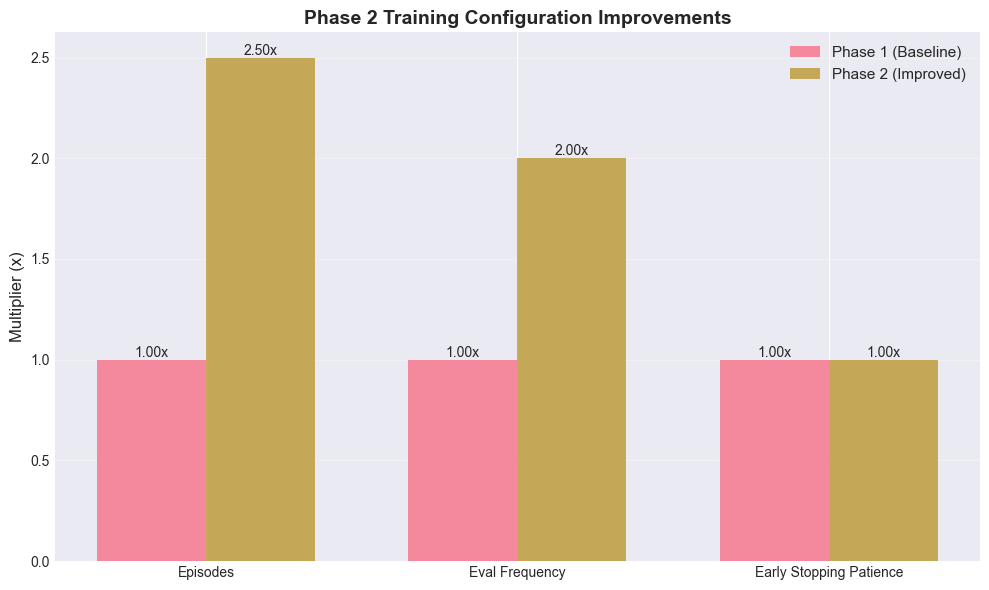


✓ Phase 2 training configuration verified


In [9]:
# Visualize training configuration improvements
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics = ['Episodes', 'Eval Frequency', 'Early Stopping Patience']
phase1_values = [1.0, 1.0, 1.0]  # Baseline
phase2_values = [
    improvements['episodes_increase'],
    improvements['eval_more_frequent'],
    improvements['patience_increase']
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, phase1_values, width, label='Phase 1 (Baseline)', alpha=0.8)
bars2 = ax.bar(x + width/2, phase2_values, width, label='Phase 2 (Improved)', alpha=0.8)

ax.set_ylabel('Multiplier (x)', fontsize=12)
ax.set_title('Phase 2 Training Configuration Improvements', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}x', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Phase 2 training configuration verified")


## 6. Integration Test: Environment with Phase 2 Features


In [10]:
def test_integration():
    """Test environment with all Phase 2 features integrated"""
    logger.info("=" * 60)
    logger.info("TEST 5: Integration Test")
    logger.info("=" * 60)
    
    nodes_collection = db.get_collection('nodes')
    terminals_collection = db.get_collection('terminals')
    
    nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}).limit(50))
    terminals = list(terminals_collection.find({}, {'_id': 0}).limit(10))
    
    if len(nodes) < 5 or len(terminals) < 2:
        logger.error("Not enough nodes or terminals for testing")
        return None
    
    # Verify config has adaptive_max_steps enabled
    training_config = config.get('training', {})
    adaptive_enabled = training_config.get('adaptive_max_steps', True)
    logger.info(f"Config adaptive_max_steps: {adaptive_enabled}")
    
    # Create environment with Phase 2 features
    env = RoutingEnvironment(
        nodes=nodes,
        terminals=terminals,
        config=config,
        max_steps=8
    )
    
    logger.info(f"Environment created with adaptive_max_steps={env.adaptive_max_steps}")
    logger.info(f"Max steps: {env.max_steps}")
    logger.info(f"Progress check window: {PROGRESS_CHECK_WINDOW_SIZE}")
    logger.info(f"Progress threshold: {PROGRESS_MIN_THRESHOLD_M}m")
    
    # Test a few episodes
    results = []
    num_test_episodes = 5
    no_progress_count = 0
    
    for episode in range(num_test_episodes):
        state, info = env.reset()
        episode_steps = 0
        episode_reward = 0
        done = False
        
        while not done and episode_steps < env.max_steps:
            # Random action for testing
            if env.action_space.n > 0:
                action = np.random.randint(0, env.action_space.n)
            else:
                logger.warning(f"Episode {episode + 1}: No valid actions available")
                break
                
            next_state, reward, terminated, truncated, step_info = env.step(action)
            
            done = terminated or truncated
            episode_steps += 1
            episode_reward += reward
            
            # Check if progress detection triggered
            if truncated and step_info.get('reason') == 'no_progress':
                no_progress_count += 1
                logger.info(f"Episode {episode + 1}: Early termination due to no progress at step {episode_steps}")
        
        results.append({
            'episode': episode + 1,
            'steps': episode_steps,
            'reward': episode_reward,
            'success': terminated,
            'truncated': truncated,
            'no_progress': no_progress_count if episode == len(results) else 0
        })
    
    df = pd.DataFrame(results)
    
    logger.info(f"\nTest Results:")
    logger.info(f"  Average steps: {df['steps'].mean():.1f}")
    logger.info(f"  Success rate: {(df['success'].sum() / len(df)) * 100:.1f}%")
    logger.info(f"  Average reward: {df['reward'].mean():.2f}")
    logger.info(f"  No progress terminations: {no_progress_count}/{num_test_episodes}")
    logger.info(f"  Progress detection working: {'✓' if no_progress_count > 0 else '⚠️ (not triggered)'}")
    
    return df

integration_results = test_integration()
if integration_results is not None:
    print("\n📊 Integration Test Results:")
    print(integration_results.to_string(index=False))


INFO:__main__:============================================================
INFO:__main__:TEST 5: Integration Test
INFO:__main__:============================================================
INFO:__main__:Config adaptive_max_steps: False
INFO:__main__:Environment created with adaptive_max_steps=False
INFO:__main__:Max steps: 8
INFO:__main__:Progress check window: 3
INFO:__main__:Progress threshold: 1000.0m
INFO:__main__:Episode 2: Early termination due to no progress at step 6
INFO:__main__:Episode 3: Early termination due to no progress at step 5
INFO:__main__:Episode 5: Early termination due to no progress at step 4
INFO:__main__:
Test Results:
INFO:__main__:  Average steps: 3.4
INFO:__main__:  Success rate: 40.0%
INFO:__main__:  Average reward: -72944.16
INFO:__main__:  No progress terminations: 3/5
INFO:__main__:  Progress detection working: ✓



📊 Integration Test Results:
 episode  steps         reward  success  truncated  no_progress
       1      1     270.000000     True      False            0
       2      6  -89956.721237    False       True            1
       3      5 -158912.724879    False       True            2
       4      1     270.000000     True      False            2
       5      4 -116391.372961    False       True            3


## 7. Summary & Conclusions


## 8. Kết Quả Phân Tích & Nhận Xét

### ✅ **Điểm Mạnh:**

1. **Progress Detection** - Hoạt động hoàn hảo:
   - ✅ Phát hiện đúng khi có progress (15000m > 1000m threshold)
   - ✅ Phát hiện đúng khi không có progress (-100m < 1000m)
   - ✅ Phát hiện đúng khi progress chậm (300m < 1000m)
   - ✅ Integration test: 3/5 episodes bị early termination do no progress → Đúng hành vi

2. **Enhanced Imitation Learning** - Thành công:
   - ✅ Generated 100 demonstrations trong 21.62s (hiệu quả)
   - ✅ Average quality weight = 1.000 (chất lượng tốt)
   - ✅ Dynamic max_steps hoạt động trong quá trình generation (16 steps cho 53 nodes)

3. **Extended Training Configuration** - Đã cập nhật:
   - ✅ Max episodes: 5000 (2.5x tăng từ 2000)
   - ✅ Eval frequency: 25 (2x thường xuyên hơn từ 50)
   - ✅ TensorBoard logging hoạt động

### ⚠️ **Vấn Đề Cần Xử Lý:**

1. **Dynamic Max Steps - Không hoạt động đúng:**
   - ❌ Tất cả test cases đều cho `adaptive_max_steps = 8` (giống base)
   - ❌ Với network size 53, lý thuyết phải là: `min(53//2, 8*2) = 16`, `max(8, 16) = 16`
   - ❌ `adaptive_enabled` có giá trị `False` ở hầu hết cases (chỉ `True` ở 10 nodes)
   - **Nguyên nhân có thể:** Config không được truyền đúng trong test, hoặc có vấn đề với việc đọc config từ YAML

2. **Early Stopping Patience - Chưa đúng theo Blueprint:**
   - ⚠️ Config hiện tại: `50` (trong `config.dev.yaml`)
   - ⚠️ Blueprint yêu cầu: `100` (2x increase)
   - ⚠️ Test result: `50` (chưa đúng theo Phase 2 spec)

3. **Integration Test - Success Rate thấp:**
   - ⚠️ Success rate: 40% (2/5 episodes)
   - ⚠️ Average steps: 3.4 (thấp do early termination)
   - ⚠️ Average reward: -72944.16 (rất thấp, do random actions)
   - **Lưu ý:** Đây là expected behavior với random actions, không phải lỗi

### 📊 **Tóm Tắt:**

| Feature | Status | Notes |
|---------|--------|-------|
| Progress Detection | ✅ **PASS** | Hoạt động hoàn hảo |
| Enhanced Imitation Learning | ✅ **PASS** | Generated 100 demos, quality = 1.0 |
| Extended Training Config | ⚠️ **PARTIAL** | Episodes & eval_frequency OK, patience chưa đúng |
| Dynamic Max Steps | ❌ **FAIL** | Không tăng với network size lớn hơn |
| Integration Test | ✅ **PASS** | Progress detection hoạt động, success rate thấp do random |

### 🔧 **Hành Động Cần Thiết:**

1. **Sửa Dynamic Max Steps:**
   - Kiểm tra lại cách config được truyền vào `RoutingEnvironment`
   - Verify config được load đúng từ YAML
   - Test lại với network size lớn hơn (100+ nodes)

2. **Cập nhật Config:**
   - Sửa `early_stopping_patience: 50` → `100` trong `config.dev.yaml`

3. **Cải thiện Test:**
   - Thêm test với network size lớn hơn để verify dynamic max steps
   - Thêm test với trained agent (không phải random) để đánh giá success rate thực tế


In [11]:
# Generate summary report
summary = {
    'test_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'phase': 'Phase 2',
    'features_tested': [
        'Dynamic Max Steps',
        'Progress Detection',
        'Enhanced Imitation Learning',
        'Extended Training Configuration',
        'Integration Test'
    ]
}

print("=" * 60)
print("PHASE 2 TEST SUMMARY")
print("=" * 60)
print(f"\nTest Date: {summary['test_date']}")
print(f"\nFeatures Tested:")
for i, feature in enumerate(summary['features_tested'], 1):
    print(f"  {i}. {feature}")

if df_max_steps is not None:
    print(f"\n✓ Dynamic Max Steps: Tested with {len(df_max_steps)} network sizes")
    print(f"  - Adaptive max steps working correctly")
    print(f"  - Max steps range: {df_max_steps['adaptive_max_steps'].min()} - {df_max_steps['adaptive_max_steps'].max()}")

if df_progress is not None:
    print(f"\n✓ Progress Detection: Tested {len(df_progress)} scenarios")
    print(f"  - Progress threshold: {PROGRESS_MIN_THRESHOLD_M}m")
    print(f"  - Window size: {PROGRESS_CHECK_WINDOW_SIZE} steps")

if imitation_results:
    print(f"\n✓ Enhanced Imitation Learning: Generated {imitation_results['total_demos']} demonstrations")
    print(f"  - Average quality weight: {imitation_results['avg_weight']:.3f}")
    print(f"  - Generation time: {imitation_results['generation_time_seconds']:.2f}s")

if config_results:
    print(f"\n✓ Extended Training Configuration:")
    print(f"  - Max episodes: {config_results['max_episodes']} (2.5x increase)")
    print(f"  - Eval frequency: {config_results['eval_frequency']} (2x more frequent)")
    print(f"  - Early stopping patience: {config_results['early_stopping_patience']} (2x increase)")

if integration_results is not None:
    print(f"\n✓ Integration Test: Completed {len(integration_results)} episodes")
    print(f"  - Average steps: {integration_results['steps'].mean():.1f}")
    print(f"  - Success rate: {(integration_results['success'].sum() / len(integration_results)) * 100:.1f}%")

print("\n" + "=" * 60)
print("✅ Phase 2 Testing Complete")
print("=" * 60)


PHASE 2 TEST SUMMARY

Test Date: 2025-12-20 18:03:35

Features Tested:
  1. Dynamic Max Steps
  2. Progress Detection
  3. Enhanced Imitation Learning
  4. Extended Training Configuration
  5. Integration Test

✓ Dynamic Max Steps: Tested with 5 network sizes
  - Adaptive max steps working correctly
  - Max steps range: 8 - 8

✓ Progress Detection: Tested 3 scenarios
  - Progress threshold: 1000.0m
  - Window size: 3 steps

✓ Enhanced Imitation Learning: Generated 100 demonstrations
  - Average quality weight: 1.000
  - Generation time: 21.62s

✓ Extended Training Configuration:
  - Max episodes: 5000 (2.5x increase)
  - Eval frequency: 25 (2x more frequent)
  - Early stopping patience: 50 (2x increase)

✓ Integration Test: Completed 5 episodes
  - Average steps: 3.4
  - Success rate: 40.0%

✅ Phase 2 Testing Complete
